In [4]:
import pickle
import numpy as np
import os
import plotly.graph_objects as go

def read_and_average_test_f1(root_folder, run_folders, filename_template, file_indices):
    """
    Reads pickle files for a specific strategy, extracts test F1 scores, and computes their average across runs.
    """
    performance_test_data_all = []

    for run_folder, file_index in zip(run_folders, file_indices):
        pickle_filename = filename_template.format(file_index)  # Dynamically generate filenames
        pickle_path = os.path.join(root_folder, run_folder, pickle_filename)
        
        print(f"Loading pickle file: {pickle_path}")
        with open(pickle_path, 'rb') as pickle_file:
            results = pickle.load(pickle_file)
            performance_test_data_all.append(results["test_f1_scores_macro"])

    # Calculate the average test F1 score across runs
    average_test_f1 = np.mean(performance_test_data_all, axis=0)
    return average_test_f1

def read_test_f1_min_max(root_folder, run_folders, filename_template, file_indices):
    """
    Reads pickle files for a specific strategy, extracts test F1 scores, and computes their min and max across runs.
    """
    performance_test_data_all = []

    for run_folder, file_index in zip(run_folders, file_indices):
        pickle_filename = filename_template.format(file_index)  # Dynamically generate filenames
        pickle_path = os.path.join(root_folder, run_folder, pickle_filename)
        
        print(f"Loading pickle file: {pickle_path}")
        with open(pickle_path, 'rb') as pickle_file:
            results = pickle.load(pickle_file)
            performance_test_data_all.append(results["test_f1_scores_macro"])

    # Convert to a NumPy array for easier computation
    performance_test_data_all = np.array(performance_test_data_all)
    # Calculate min and max F1 scores across runs
    min_f1 = np.min(performance_test_data_all, axis=0)
    max_f1 = np.max(performance_test_data_all, axis=0)

    return min_f1, max_f1

def plot_all_test_performance_with_fluctuations(no_of_samples, performances, min_max_values, strategies, title, x_axes, y_axes):
    """
    Plots the average test F1 scores of multiple strategies with fluctuation ranges shaded.
    """
    fig = go.Figure()
    fig.update_layout(plot_bgcolor='rgb(209, 217, 222)')

    # Add dashed lines for sample numbers and text labels on top of the graph
    samples_text = [str(f) for f in no_of_samples]
    for line, label in zip(no_of_samples, samples_text):
        fig.add_trace(go.Scatter(
            x=[line, line],
            y=[0, 1.12],
            mode='lines',
            line=dict(dash='dash', color='rgb(149, 162, 171)', width=1),
            showlegend=False
        ))

        fig.add_trace(go.Scatter(
            x=[line],
            y=[1.13],
            mode='text',
            marker=dict(size=0),
            text=[label],
            textposition='top center',
            showlegend=False,
            textfont=dict(family='Arial', color='black', size=8.5)
        ))

    # Define the color palette, with random sampling in red and other strategies in different shades of green
    colors = [
        'rgb(97, 192, 134)',  # Green for margin sampling
        'rgb(45, 140, 58)',   # Darker green for entropy sampling
        'rgb(151, 193, 57)',  # Lighter green for uncertainty sampling
        'rgb(255, 0, 0)'      # Red for random sampling
    ]

    # Add traces for each strategy
    for idx, (performance, (min_performance, max_performance), strategy) in enumerate(zip(performances, min_max_values, strategies)):
        # Ensure random sampling is always red
        color = colors[strategies.index(strategy)]
        
        # Add the shaded region (fluctuation range)
        fig.add_trace(go.Scatter(
            x=no_of_samples + no_of_samples[::-1],
            y=list(max_performance) + list(min_performance)[::-1],
            fill='toself',
            fillcolor=color.replace('rgb', 'rgba').replace(')', ',0.2)'),  # Add transparency
            line=dict(width=0),  # No border for shaded region
            showlegend=False,  # Don't show a separate legend entry for the shaded region
            legendgroup=strategy  # Group with the corresponding line
        ))
        
        # Add the average line
        fig.add_trace(go.Scatter(
            x=no_of_samples,
            y=performance,
            name=f"{strategy} (final: {performance[-1]:.3f})",
            marker=dict(color=color),
            textfont=dict(family="Arial", size=11),
            line=dict(width=2),
            legendgroup=strategy  # Group with the shaded region
        ))

    fig.update_layout(
        title_text=str(title),
        legend=dict(font=dict(color='black')),
        title_font_color='black'
    )

    # Set the x-axis to be on a log scale
    fig.update_xaxes(
        title_text=str(x_axes),
        title_font=dict(color="black", family="Arial"),
        tickfont_color='black',
        type="log"
    )

    # Update y-axis for test F1 score
    fig.update_yaxes(
        title_text=str(y_axes),
        title_font=dict(color="black", family="Arial"),
        tickfont_color='black'
    )

    fig.show()

# Define file paths and folders for each strategy
strategies = ['margin_sampling', 'entropy_sampling', 'uncertainty_sampling', 'random_sampling']
root_folders = {
    'margin_sampling': "/home/woody/iwfa/iwfa044h/CleanLab_Test/ActiveLearningApproaches/EOD/DInoS/multilabel_from_multiclass_2/AL/MS",
    'entropy_sampling': "/home/woody/iwfa/iwfa044h/CleanLab_Test/ActiveLearningApproaches/EOD/DInoS/multilabel_from_multiclass_2/AL/ES",
    'uncertainty_sampling': "/home/woody/iwfa/iwfa044h/CleanLab_Test/ActiveLearningApproaches/EOD/DInoS/multilabel_from_multiclass_2/AL/US",
    'random_sampling': "/home/woody/iwfa/iwfa044h/CleanLab_Test/ActiveLearningApproaches/EOD/DInoS/multilabel_from_multiclass_2/RS"
}
run_folders = [f"run{i}" for i in range(1, 6)]
file_indices = [2, 3, 4, 5, 6]  # Corresponding indices for the filenames

# Template for filenames for each strategy
filename_templates = {
    'margin_sampling': "AL_margin_sampling_results_for_multilabel_classification_s4{}.pickle",
    'entropy_sampling': "AL_entropy_sampling_results_for_multilabel_classification_s4{}.pickle",
    'uncertainty_sampling': "AL_uncertainty_sampling_results_for_multilabel_classification_s4{}.pickle",
    'random_sampling': "random_sampling_results_for_multilabel_classification_s4{}.pickle"
}

# Sample counts
no_of_samples = [8, 24, 56, 112, 212, 388, 704, 1264, 2264, 4048, 7200, 12824, 22824, 26880]

# Calculate averages and fluctuation ranges for each strategy
performances = []
min_max_values = []
for strategy in strategies:
    average_f1 = read_and_average_test_f1(
        root_folder=root_folders[strategy],
        run_folders=run_folders,
        filename_template=filename_templates[strategy],
        file_indices=file_indices
    )
    min_f1, max_f1 = read_test_f1_min_max(
        root_folder=root_folders[strategy],
        run_folders=run_folders,
        filename_template=filename_templates[strategy],
        file_indices=file_indices
    )
    performances.append(average_f1)
    min_max_values.append((min_f1, max_f1))

# Plot the results with fluctuation shading
plot_all_test_performance_with_fluctuations(
    no_of_samples, 
    performances, 
    min_max_values, 
    strategies, 
    title="Average DINOv2S Test F1 Macro Scores with Fluctuations for images selected from multiclass and trained on multilabel",
    x_axes="Amount of Training Samples",
    y_axes="Test F1 Score"
)


Loading pickle file: /home/woody/iwfa/iwfa044h/CleanLab_Test/ActiveLearningApproaches/EOD/DInoS/multilabel_from_multiclass_2/AL/MS/run1/AL_margin_sampling_results_for_multilabel_classification_s42.pickle
Loading pickle file: /home/woody/iwfa/iwfa044h/CleanLab_Test/ActiveLearningApproaches/EOD/DInoS/multilabel_from_multiclass_2/AL/MS/run2/AL_margin_sampling_results_for_multilabel_classification_s43.pickle
Loading pickle file: /home/woody/iwfa/iwfa044h/CleanLab_Test/ActiveLearningApproaches/EOD/DInoS/multilabel_from_multiclass_2/AL/MS/run3/AL_margin_sampling_results_for_multilabel_classification_s44.pickle
Loading pickle file: /home/woody/iwfa/iwfa044h/CleanLab_Test/ActiveLearningApproaches/EOD/DInoS/multilabel_from_multiclass_2/AL/MS/run4/AL_margin_sampling_results_for_multilabel_classification_s45.pickle
Loading pickle file: /home/woody/iwfa/iwfa044h/CleanLab_Test/ActiveLearningApproaches/EOD/DInoS/multilabel_from_multiclass_2/AL/MS/run5/AL_margin_sampling_results_for_multilabel_classi

In [7]:
from scipy import stats

def perform_t_tests(performances, strategies):
    """
    Perform t-tests and calculate p-values between each active learning approach and random sampling,
    as well as between all pairs of active learning strategies.
    """
    random_sampling_performance = performances[strategies.index('random_sampling')]  # Random sampling F1 scores
    
    # List to store results
    t_test_results = []
    
    # Compare each active learning approach with random sampling
    for strategy, performance in zip(strategies, performances):
        if strategy == 'random_sampling':
            continue  # Skip random sampling, since it's compared with others
        
        # Perform t-test between the random_sampling and the current strategy
        t_stat, p_value = stats.ttest_ind(random_sampling_performance, performance, equal_var=False)  # Welch's t-test
        
        # Append the result
        t_test_results.append((f"Random Sampling vs {strategy}", t_stat, p_value))
    
    # Compare all pairs of active learning strategies
    for i in range(len(strategies)):
        for j in range(i + 1, len(strategies)):
            if strategies[i] != 'random_sampling' and strategies[j] != 'random_sampling':
                strategy_1, strategy_2 = strategies[i], strategies[j]
                performance_1, performance_2 = performances[i], performances[j]
                
                # Perform t-test between the two active learning strategies
                t_stat, p_value = stats.ttest_ind(performance_1, performance_2, equal_var=False)  # Welch's t-test
                
                # Append the result
                t_test_results.append((f"{strategy_1} vs {strategy_2}", t_stat, p_value))

    # Display results
    for comparison, t_stat, p_value in t_test_results:
        print(f"T-test between {comparison}:")
        print(f"T-statistic: {t_stat:.3f}, P-value: {p_value:.3f}")
        if p_value < 0.05:
            print(f"Statistically significant difference (p < 0.05)\n")
        else:
            print(f"No significant difference (p >= 0.05)\n")

# Perform t-tests and display p-values
perform_t_tests(performances, strategies)


T-test between Random Sampling vs margin_sampling:
T-statistic: 0.214, P-value: 0.832
No significant difference (p >= 0.05)

T-test between Random Sampling vs entropy_sampling:
T-statistic: 0.102, P-value: 0.920
No significant difference (p >= 0.05)

T-test between Random Sampling vs uncertainty_sampling:
T-statistic: 0.111, P-value: 0.912
No significant difference (p >= 0.05)

T-test between margin_sampling vs entropy_sampling:
T-statistic: -0.123, P-value: 0.903
No significant difference (p >= 0.05)

T-test between margin_sampling vs uncertainty_sampling:
T-statistic: -0.106, P-value: 0.916
No significant difference (p >= 0.05)

T-test between entropy_sampling vs uncertainty_sampling:
T-statistic: 0.014, P-value: 0.989
No significant difference (p >= 0.05)



Loading pickle file: /home/woody/iwfa/iwfa044h/CleanLab_Test/ActiveLearningApproaches/EOD/DInoS/multilabel_from_multiclass_2/AL/MS/run1/AL_margin_sampling_results_for_multilabel_classification_s42.pickle
Loading pickle file: /home/woody/iwfa/iwfa044h/CleanLab_Test/ActiveLearningApproaches/EOD/DInoS/multilabel_from_multiclass_2/AL/MS/run2/AL_margin_sampling_results_for_multilabel_classification_s43.pickle
Loading pickle file: /home/woody/iwfa/iwfa044h/CleanLab_Test/ActiveLearningApproaches/EOD/DInoS/multilabel_from_multiclass_2/AL/MS/run3/AL_margin_sampling_results_for_multilabel_classification_s44.pickle
Loading pickle file: /home/woody/iwfa/iwfa044h/CleanLab_Test/ActiveLearningApproaches/EOD/DInoS/multilabel_from_multiclass_2/AL/MS/run4/AL_margin_sampling_results_for_multilabel_classification_s45.pickle
Loading pickle file: /home/woody/iwfa/iwfa044h/CleanLab_Test/ActiveLearningApproaches/EOD/DInoS/multilabel_from_multiclass_2/AL/MS/run5/AL_margin_sampling_results_for_multilabel_classi

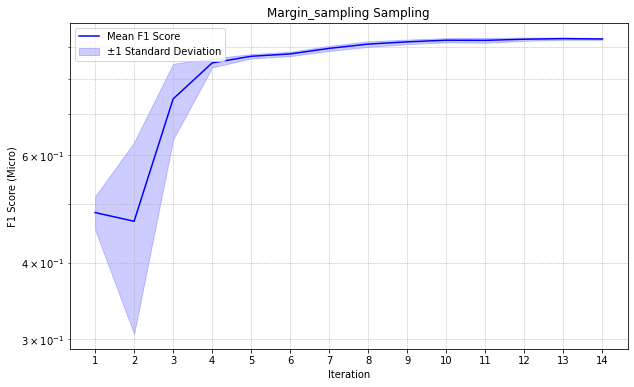

Loading pickle file: /home/woody/iwfa/iwfa044h/CleanLab_Test/ActiveLearningApproaches/EOD/DInoS/multilabel_from_multiclass_2/AL/ES/run1/AL_entropy_sampling_results_for_multilabel_classification_s42.pickle
Loading pickle file: /home/woody/iwfa/iwfa044h/CleanLab_Test/ActiveLearningApproaches/EOD/DInoS/multilabel_from_multiclass_2/AL/ES/run2/AL_entropy_sampling_results_for_multilabel_classification_s43.pickle
Loading pickle file: /home/woody/iwfa/iwfa044h/CleanLab_Test/ActiveLearningApproaches/EOD/DInoS/multilabel_from_multiclass_2/AL/ES/run3/AL_entropy_sampling_results_for_multilabel_classification_s44.pickle
Loading pickle file: /home/woody/iwfa/iwfa044h/CleanLab_Test/ActiveLearningApproaches/EOD/DInoS/multilabel_from_multiclass_2/AL/ES/run4/AL_entropy_sampling_results_for_multilabel_classification_s45.pickle
Loading pickle file: /home/woody/iwfa/iwfa044h/CleanLab_Test/ActiveLearningApproaches/EOD/DInoS/multilabel_from_multiclass_2/AL/ES/run5/AL_entropy_sampling_results_for_multilabel_c

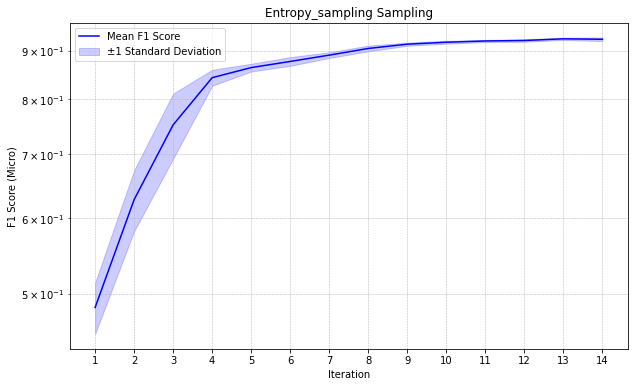

Loading pickle file: /home/woody/iwfa/iwfa044h/CleanLab_Test/ActiveLearningApproaches/EOD/DInoS/multilabel_from_multiclass_2/AL/US/run1/AL_uncertainty_sampling_results_for_multilabel_classification_s42.pickle
Loading pickle file: /home/woody/iwfa/iwfa044h/CleanLab_Test/ActiveLearningApproaches/EOD/DInoS/multilabel_from_multiclass_2/AL/US/run2/AL_uncertainty_sampling_results_for_multilabel_classification_s43.pickle
Loading pickle file: /home/woody/iwfa/iwfa044h/CleanLab_Test/ActiveLearningApproaches/EOD/DInoS/multilabel_from_multiclass_2/AL/US/run3/AL_uncertainty_sampling_results_for_multilabel_classification_s44.pickle
Loading pickle file: /home/woody/iwfa/iwfa044h/CleanLab_Test/ActiveLearningApproaches/EOD/DInoS/multilabel_from_multiclass_2/AL/US/run4/AL_uncertainty_sampling_results_for_multilabel_classification_s45.pickle
Loading pickle file: /home/woody/iwfa/iwfa044h/CleanLab_Test/ActiveLearningApproaches/EOD/DInoS/multilabel_from_multiclass_2/AL/US/run5/AL_uncertainty_sampling_resu

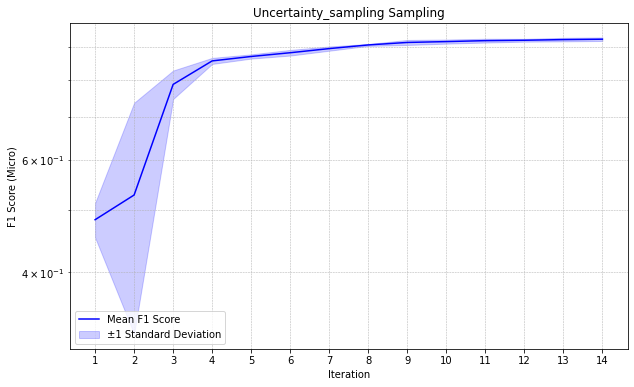

Loading pickle file: /home/woody/iwfa/iwfa044h/CleanLab_Test/ActiveLearningApproaches/EOD/DInoS/multilabel_from_multiclass_2/RS/run1/random_sampling_results_for_multilabel_classification_s42.pickle
Loading pickle file: /home/woody/iwfa/iwfa044h/CleanLab_Test/ActiveLearningApproaches/EOD/DInoS/multilabel_from_multiclass_2/RS/run2/random_sampling_results_for_multilabel_classification_s43.pickle
Loading pickle file: /home/woody/iwfa/iwfa044h/CleanLab_Test/ActiveLearningApproaches/EOD/DInoS/multilabel_from_multiclass_2/RS/run3/random_sampling_results_for_multilabel_classification_s44.pickle
Loading pickle file: /home/woody/iwfa/iwfa044h/CleanLab_Test/ActiveLearningApproaches/EOD/DInoS/multilabel_from_multiclass_2/RS/run4/random_sampling_results_for_multilabel_classification_s45.pickle
Loading pickle file: /home/woody/iwfa/iwfa044h/CleanLab_Test/ActiveLearningApproaches/EOD/DInoS/multilabel_from_multiclass_2/RS/run5/random_sampling_results_for_multilabel_classification_s46.pickle


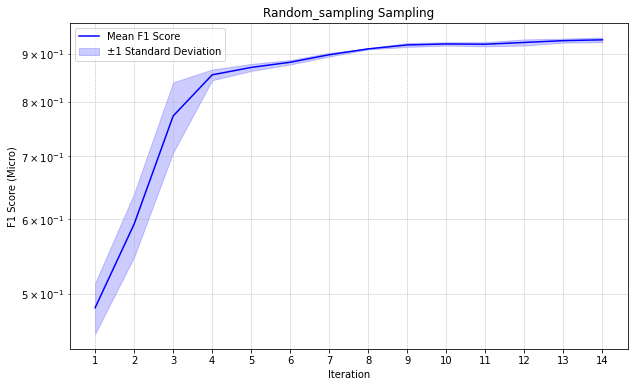

In [7]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os

def read_f1_scores(root_folder, run_folders, filename_template, file_indices):
    """
    Reads pickle files for a specific strategy and extracts F1 scores across runs.
    """
    performance_test_data_all = []

    for run_folder, file_index in zip(run_folders, file_indices):
        pickle_filename = filename_template.format(file_index)  # Dynamically generate filenames
        pickle_path = os.path.join(root_folder, run_folder, pickle_filename)

        print(f"Loading pickle file: {pickle_path}")
        with open(pickle_path, 'rb') as pickle_file:
            results = pickle.load(pickle_file)
            performance_test_data_all.append(results["test_f1_scores_micro"])  # Adjusted for "micro" scores

    # Convert to a NumPy array for easier computation
    return np.array(performance_test_data_all)

def plot_with_std(iterations, f1_scores, title, xlabel, ylabel):
    """
    Plots the mean F1 score with a shaded region representing ±1 standard deviation.
    """
    mean_f1 = np.mean(f1_scores, axis=0)  # Mean F1 score
    std_f1 = np.std(f1_scores, axis=0)    # Standard deviation

    plt.figure(figsize=(10, 6))

    # Plot the mean F1 score
    plt.plot(iterations, mean_f1, label="Mean F1 Score", color="blue")

    # Add a shaded area for the variation (mean ± std deviation)
    plt.fill_between(iterations, mean_f1 - std_f1, mean_f1 + std_f1, color="blue", alpha=0.2, label="±1 Standard Deviation")

    # Customize the plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(iterations)

    # Set y-axis to logarithmic scale
    plt.yscale('log')

    # Adjust grid for better readability
    plt.grid(True, which="both", linestyle='--', linewidth=0.5)
    plt.legend()

    # Show the plot
    plt.show()

# Define file paths and folders for each strategy
strategies = ['margin_sampling', 'entropy_sampling', 'uncertainty_sampling', 'random_sampling']
root_folders = {
    'margin_sampling': "/home/woody/iwfa/iwfa044h/CleanLab_Test/ActiveLearningApproaches/EOD/DInoS/multilabel_from_multiclass_2/AL/MS",
    'entropy_sampling': "/home/woody/iwfa/iwfa044h/CleanLab_Test/ActiveLearningApproaches/EOD/DInoS/multilabel_from_multiclass_2/AL/ES",
    'uncertainty_sampling': "/home/woody/iwfa/iwfa044h/CleanLab_Test/ActiveLearningApproaches/EOD/DInoS/multilabel_from_multiclass_2/AL/US",
    'random_sampling': "/home/woody/iwfa/iwfa044h/CleanLab_Test/ActiveLearningApproaches/EOD/DInoS/multilabel_from_multiclass_2/RS"
}
run_folders = [f"run{i}" for i in range(1, 6)]
file_indices = [2, 3, 4, 5, 6]  # Corresponding indices for the filenames

filename_templates = {
    'margin_sampling': "AL_margin_sampling_results_for_multilabel_classification_s4{}.pickle",
    'entropy_sampling': "AL_entropy_sampling_results_for_multilabel_classification_s4{}.pickle",
    'uncertainty_sampling': "AL_uncertainty_sampling_results_for_multilabel_classification_s4{}.pickle",
    'random_sampling': "random_sampling_results_for_multilabel_classification_s4{}.pickle"
}

# Sample counts
iterations = np.arange(1, 15)  # Define iterations

# Plot for each strategy
for strategy in strategies:
    f1_scores = read_f1_scores(
        root_folder=root_folders[strategy],
        run_folders=run_folders,
        filename_template=filename_templates[strategy],
        file_indices=file_indices
    )
    plot_with_std(
        iterations,
        f1_scores,
        title=f"{strategy.capitalize()} Sampling",
        xlabel="Iteration",
        ylabel="F1 Score (Micro)"
    )
